In [1]:
import torch # used for PyTorch datasets and deep learning
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer # used for NLP tokenizartion
from tqdm.auto import tqdm # progress bar for loops
from sklearn.model_selection import train_test_split # splits data into training and test sets

In [2]:
class ProductSearchDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset # takes in a dataset
    
    def __len__(self):
        return self.data.shape[0] # return total # of rows (products) in the dataset

    def __getitem__(self, index):
        row = self.data.iloc[index] # retrieve a row based on index

        # extract data
        product_id = row['id']
        product_desc = row['description']
        product_cluster = row['label']
        
        # get all queries
        product_queries = row[['query_1', 'query_2', 'query_3', 'query_4', 'query_5']].values
    
        # randomly select one query for training
        query = np.random.choice(product_queries)
    
        return query, product_desc, product_id, product_cluster

In [3]:
df = pd.read_csv("cd_vinyl_products_with_sample_queries.csv")

In [4]:
df.head()

,id,title,description,label,query_1,query_2,query_3,query_4,query_5
0,B00BV9RZSO,Elephant,doulbe 180gm vinyl lp pressing of this 2003 al...,67,"""white stripes vinyl LP 2003""","""garage rock revival music""","""analog recording equipment bands""","""Detroit indie music albums""","""raw simplicity music composition"""
1,B0009ELZAG,The Beach Boys: Pet Sounds,the tracks are 1 wouldnt it be nice 2 you stil...,45,"""Pet Sounds bonus tracks vinyl""","""Beach Boys album 1966""","""Brian Wilson music compositions""","""California pop music LP""","""melodic pop rock records"""
2,B00M889IDM,Eric Clapton & Friends: The Breeze,eric clapton has often stated that jj cale is ...,54,"""Eric Clapton tribute album JJ Cale""","""rock history appreciation music""","""famous musicians collaborations LP""","""JJ Cale covers by artists""","""1972 single call me the breeze"""
3,B00NQKWA6S,The Endless River,2014 release the 15th and final studio album f...,3,"""David Gilmour final studio album""","""British rock band unreleased tracks""","""Pink Floyd leftovers project""","""veteran rock musicians LP""","""coproduced by Phil Manzanera"""
4,B08HGPZ1Q5,American Beauty,the crown jewel of the deads studio output fea...,63,"""Grateful Dead crown jewel LP""","""50th-anniversary remastered vinyl""","""psychedelic rock classics""","""180-gram vinyl reissue""","""tracklist box of rain"""


In [6]:
train_dataset, val_dataset = train_test_split(df, test_size=0.2, random_state=3723)
train_dataset.reset_index(drop=True, inplace=True)
val_dataset.reset_index(drop=True, inplace=True)

In [7]:
class QueryEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # use fewer transformer layers for queries since they're shorter
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=2,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        # move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)
        
        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # use mean pooling instead of CLS token for queries
        # this helps capture information from all tokens in short queries
        mask_expanded = attention_mask.unsqueeze(-1).expand(x.size())
        sum_embeddings = torch.sum(x * mask_expanded, 1)
        sum_mask = torch.sum(mask_expanded, 1)
        mean_embeddings = sum_embeddings / sum_mask
        return self.projection(mean_embeddings)

In [8]:
class ProductEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # use more transformer layers for product descriptions since they're longer
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=4,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        # move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)
        
        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # use CLS token for product descriptions
        cls_embed = x[:,0,:]
        return self.projection(cls_embed)

In [9]:
def batch_hard_negative_sampling(product_ids, cluster_ids, product_embeddings, num_negatives=1):
    """
    Sample hard negatives from the current batch, ensuring negatives come from different clusters.

    Args:
        product_ids (list): List of product IDs in the batch.
        cluster_ids (list): List of corresponding cluster IDs in the batch.
        product_embeddings (torch.Tensor): Tensor of product embeddings in the batch [batch_size, embed_dim].
        num_negatives (int): Number of negatives per query.

    Returns:
        neg_embeddings (torch.Tensor): Tensor of hard negative product embeddings [batch_size, num_negatives, embed_dim].
    """
    batch_size = len(product_ids)
    neg_samples = []

    for i in range(batch_size):
        # get current cluster ID
        current_cluster = cluster_ids[i]

        # find indices of products in the batch from a different cluster
        negative_indices = [j for j in range(batch_size) if cluster_ids[j] != current_cluster]

        # sample negatives
        sampled_negatives = random.sample(negative_indices, num_negatives)
        
        # store their embeddings
        neg_samples.append(product_embeddings[sampled_negatives])

    # stack negatives into a tensor [batch_size, num_negatives, embed_dim]
    neg_embeddings = torch.stack(neg_samples).to(product_embeddings.device)
    
    return neg_embeddings

In [10]:
def evaluate_model(query_encoder, product_encoder, eval_dataset, tokenizer, query_max_len, product_max_len, k=10, device='cuda'):
    """
    Evaluate the model on the evaluation dataset
    
    Args:
        query_encoder: Query encoder model
        product_encoder: Product encoder model
        eval_dataset: Evaluation dataset
        tokenizer: Tokenizer
        query_max_len: Maximum query length
        product_max_len: Maximum product description length
        k: Number of top results to consider for metrics
        device: Device to use for computations
    """
    query_encoder.eval()
    product_encoder.eval()
    
    # create evaluation dataloader
    eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=8, shuffle=False)
    
    # first pass: encode all products
    all_product_ids = []
    all_product_embeddings = []
    
    with torch.no_grad():
        for batch_data in tqdm(eval_dataloader, desc="Encoding Products"):
            _, product_descs, product_ids, _ = batch_data
            
            product_tokens = tokenizer(
                product_descs, 
                padding=True, 
                truncation=True, 
                return_tensors="pt", 
                max_length=product_max_len
            )
            
            product_embeddings = product_encoder(product_tokens)
            product_embeddings = torch.nn.functional.normalize(product_embeddings, p=2, dim=1)
            
            all_product_ids.extend(product_ids)
            all_product_embeddings.append(product_embeddings.cpu())  # move to CPU to save GPU memory
    
    # concatenate all product embeddings
    all_product_embeddings = torch.cat(all_product_embeddings, dim=0)
    
    # second pass: evaluate queries
    total_queries = 0
    hits_at_k = 0
    mrr = 0.0  # mean Reciprocal Rank
    
    with torch.no_grad():
        for batch_data in tqdm(eval_dataloader, desc="Evaluating Queries"):
            queries, _, product_ids, _ = batch_data
            
            query_tokens = tokenizer(
                queries, 
                padding=True, 
                truncation=True, 
                return_tensors="pt", 
                max_length=query_max_len
            )
            
            query_embeddings = query_encoder(query_tokens)
            query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)
            
            # move query embeddings to CPU for comparison with all products
            query_embeddings_cpu = query_embeddings.cpu()
            
            # compute similarities with all products
            similarities = query_embeddings_cpu @ all_product_embeddings.T
            
            # get top-k indices
            _, top_indices = torch.topk(similarities, k=k, dim=1)
            
            # convert to list for evaluation
            for i, (query_id, true_product_id) in enumerate(zip(range(len(queries)), product_ids)):
                total_queries += 1
                top_k_product_ids = [all_product_ids[idx] for idx in top_indices[i].tolist()]
                
                # check if true product is in top-k
                if true_product_id in top_k_product_ids:
                    hits_at_k += 1
                    # calculate reciprocal rank
                    rank = top_k_product_ids.index(true_product_id) + 1
                    mrr += 1.0 / rank
    
    # calculate metrics
    hits_at_k_rate = hits_at_k / total_queries if total_queries > 0 else 0
    mrr = mrr / total_queries if total_queries > 0 else 0
    
    print(f"Evaluation Metrics:")
    print(f"Hits@{k}: {hits_at_k_rate:.4f}")
    print(f"MRR: {mrr:.4f}")

    return hits_at_k_rate, mrr

In [11]:
def in_batch_negative_sampling_loss(query_embeddings, product_embeddings, negative_embeddings, temperature=0.1):
    """
    Compute in-batch negative sampling loss (InfoNCE loss) with hard negatives.

    Args:
        query_embeddings: Query embeddings [batch_size, embed_dim]
        product_embeddings: Product embeddings [batch_size, embed_dim]
        negative_embeddings: Hard negative product embeddings [batch_size, embed_dim]
        temperature: Temperature parameter for softmax.

    Returns:
        loss: InfoNCE loss
    """
    batch_size = query_embeddings.shape[0]

    # squeeze negative embeddings to remove the unnecessary dimension
    negative_embeddings = negative_embeddings.squeeze(1)

    # compute similarity scores
    positive_sim = (query_embeddings * product_embeddings).sum(dim=1) / temperature
    negative_sim = (query_embeddings @ negative_embeddings.T) / temperature  # Hard negatives

    # stack positives and negatives
    logits = torch.cat([positive_sim.unsqueeze(1), negative_sim], dim=1)

    # labels: First column (positive pair) is correct
    labels = torch.zeros(batch_size, dtype=torch.long, device=query_embeddings.device)

    # compute loss
    loss = torch.nn.functional.cross_entropy(logits, labels)

    return loss

In [12]:
def train_embedding_model(dataset, num_epochs=10, learning_rate=1e-4, eval_dataset=None, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    dataset = ProductSearchDataset(dataset)
    eval_dataset = ProductSearchDataset(eval_dataset)

    embed_size = 512
    output_embed_size = 128
    query_max_len = 32
    product_max_len = 512
    batch_size = 8

    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    # initialize encoders
    query_encoder = QueryEncoder(vocab_size=tokenizer.vocab_size, embed_dim=embed_size, output_embed_dim=output_embed_size).to(device)
    product_encoder = ProductEncoder(vocab_size=tokenizer.vocab_size, embed_dim=embed_size, output_embed_dim=output_embed_size).to(device)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(list(query_encoder.parameters()) + list(product_encoder.parameters()), lr=learning_rate)

    scaler = torch.amp.GradScaler(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    total_steps = len(dataloader) * num_epochs
    main_progress_bar = tqdm(total=total_steps, desc="Training Progress", position=0)

    best_hits = 0
    patience_counter = 0
    best_query_encoder_weights = None
    best_product_encoder_weights = None

    
    hits_log = []
    mrr_log = []
    
    for epoch in range(num_epochs):
        # early stopping check
        if patience_counter == patience:
            break
        
        query_encoder.train()
        product_encoder.train()
        epoch_loss = []

        epoch_desc = f"Epoch {epoch+1}/{num_epochs}"
        epoch_progress = tqdm(dataloader, desc=epoch_desc, leave=False, position=1)

        for batch_idx, batch_data in enumerate(epoch_progress):
            queries, product_descs, product_ids, cluster_ids = batch_data

            query_tokens = tokenizer(queries, padding=True, truncation=True, return_tensors="pt", max_length=query_max_len).to(device)
            product_tokens = tokenizer(product_descs, padding=True, truncation=True, return_tensors="pt", max_length=product_max_len).to(device)

            with torch.amp.autocast(device.type):
                query_embeddings = query_encoder(query_tokens)
                product_embeddings = product_encoder(product_tokens)

                query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)
                product_embeddings = torch.nn.functional.normalize(product_embeddings, p=2, dim=1)

                # get hard negatives from the batch
                negative_embeddings = batch_hard_negative_sampling(product_ids, cluster_ids, product_embeddings, num_negatives=1)

                loss = in_batch_negative_sampling_loss(query_embeddings, product_embeddings, negative_embeddings)

            epoch_loss.append(loss.item())

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            main_progress_bar.update(1)
            epoch_progress.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_loss = np.mean(epoch_loss)
        print(f"\nEpoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

        scheduler.step(avg_loss)

        if eval_dataset is not None:
            print("\nEvaluating model...")
            hits_in_top_k, mrr = evaluate_model(query_encoder, product_encoder, eval_dataset, tokenizer, query_max_len, product_max_len, device=device)
            if hits_in_top_k > best_hits:
                best_hits = hits_in_top_k
                best_query_encoder_weights = query_encoder.state_dict()
                best_product_encoder_weights = product_encoder.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            hits_log.append(hits_in_top_k)
            mrr_log.append(mrr)

    main_progress_bar.close()

    # load the model weights with the best validation hits
    query_encoder.load_state_dict(best_query_encoder_weights)
    product_encoder.load_state_dict(best_product_encoder_weights)

    return query_encoder, product_encoder, hits_log, mrr_log

In [19]:
query_encoder, product_encoder, hits_in_top_k_history, mrr_history = train_embedding_model(train_dataset, num_epochs=100, learning_rate=1e-5, eval_dataset=val_dataset, patience=20)

Using device: cuda


Training Progress:   0%|          | 0/2800 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 1/100, Average Loss: 2.2059

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1964
MRR: 0.0919


Epoch 2/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 2/100, Average Loss: 2.1840

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2321
MRR: 0.0641


Epoch 3/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 3/100, Average Loss: 2.1831

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1964
MRR: 0.0627


Epoch 4/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 4/100, Average Loss: 2.1513

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1964
MRR: 0.0485


Epoch 5/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 5/100, Average Loss: 2.1565

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2143
MRR: 0.0589


Epoch 6/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 6/100, Average Loss: 2.1634

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2143
MRR: 0.0425


Epoch 7/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 7/100, Average Loss: 2.1209

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1786
MRR: 0.0736


Epoch 8/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 8/100, Average Loss: 2.1506

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1607
MRR: 0.0631


Epoch 9/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 9/100, Average Loss: 2.1197

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1964
MRR: 0.0431


Epoch 10/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 10/100, Average Loss: 2.0899

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2321
MRR: 0.1157


Epoch 11/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 11/100, Average Loss: 2.0715

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1964
MRR: 0.0768


Epoch 12/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 12/100, Average Loss: 2.0409

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2321
MRR: 0.1241


Epoch 13/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 13/100, Average Loss: 2.0145

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2857
MRR: 0.0679


Epoch 14/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 14/100, Average Loss: 1.9702

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2679
MRR: 0.0871


Epoch 15/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 15/100, Average Loss: 1.8232

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2321
MRR: 0.0877


Epoch 16/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 16/100, Average Loss: 1.7788

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3750
MRR: 0.0888


Epoch 17/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 17/100, Average Loss: 1.6933

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2321
MRR: 0.1375


Epoch 18/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 18/100, Average Loss: 1.6724

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3929
MRR: 0.1272


Epoch 19/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 19/100, Average Loss: 1.6085

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2679
MRR: 0.0958


Epoch 20/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 20/100, Average Loss: 1.5589

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2857
MRR: 0.1285


Epoch 21/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 21/100, Average Loss: 1.5082

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3214
MRR: 0.1016


Epoch 22/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 22/100, Average Loss: 1.3847

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3393
MRR: 0.0912


Epoch 23/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 23/100, Average Loss: 1.3631

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3036
MRR: 0.0972


Epoch 24/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 24/100, Average Loss: 1.3857

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2857
MRR: 0.1040


Epoch 25/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 25/100, Average Loss: 1.3435

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3036
MRR: 0.1496


Epoch 26/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 26/100, Average Loss: 1.3072

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3571
MRR: 0.1120


Epoch 27/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 27/100, Average Loss: 1.2696

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3750
MRR: 0.1299


Epoch 28/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 28/100, Average Loss: 1.1790

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3393
MRR: 0.1591


Epoch 29/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 29/100, Average Loss: 1.1732

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2857
MRR: 0.1130


Epoch 30/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 30/100, Average Loss: 1.1972

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3571
MRR: 0.1424


Epoch 31/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 31/100, Average Loss: 1.2482

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3929
MRR: 0.1275


Epoch 32/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 32/100, Average Loss: 1.1675

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3393
MRR: 0.1202


Epoch 33/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 33/100, Average Loss: 1.1152

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3571
MRR: 0.1675


Epoch 34/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 34/100, Average Loss: 1.1671

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3393
MRR: 0.1693


Epoch 35/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 35/100, Average Loss: 1.0631

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3036
MRR: 0.0919


Epoch 36/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 36/100, Average Loss: 1.1101

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4107
MRR: 0.1680


Epoch 37/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 37/100, Average Loss: 1.1125

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3750
MRR: 0.1526


Epoch 38/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 38/100, Average Loss: 1.0298

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2857
MRR: 0.0981


Epoch 39/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 39/100, Average Loss: 1.0656

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3214
MRR: 0.1746


Epoch 40/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 40/100, Average Loss: 0.9736

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4643
MRR: 0.1905


Epoch 41/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 41/100, Average Loss: 0.9923

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3036
MRR: 0.1334


Epoch 42/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 42/100, Average Loss: 0.9240

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4107
MRR: 0.1402


Epoch 43/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 43/100, Average Loss: 0.9925

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3393
MRR: 0.1098


Epoch 44/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 44/100, Average Loss: 1.0052

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4107
MRR: 0.1825


Epoch 45/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 45/100, Average Loss: 0.9065

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4286
MRR: 0.1691


Epoch 46/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 46/100, Average Loss: 1.0003

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5000
MRR: 0.2167


Epoch 47/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 47/100, Average Loss: 0.9603

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4107
MRR: 0.1726


Epoch 48/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 48/100, Average Loss: 0.9045

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4286
MRR: 0.1405


Epoch 49/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 49/100, Average Loss: 0.9094

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4643
MRR: 0.1967


Epoch 50/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 50/100, Average Loss: 0.8912

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3750
MRR: 0.1788


Epoch 51/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 51/100, Average Loss: 0.8536

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3393
MRR: 0.1506


Epoch 52/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 52/100, Average Loss: 0.9072

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3929
MRR: 0.2240


Epoch 53/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 53/100, Average Loss: 0.8647

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3571
MRR: 0.1235


Epoch 54/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 54/100, Average Loss: 0.8587

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3571
MRR: 0.1566


Epoch 55/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 55/100, Average Loss: 0.8658

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4286
MRR: 0.1861


Epoch 56/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 56/100, Average Loss: 0.8677

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4286
MRR: 0.2025


Epoch 57/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 57/100, Average Loss: 0.8334

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4286
MRR: 0.1751


Epoch 58/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 58/100, Average Loss: 0.8381

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4464
MRR: 0.2006


Epoch 59/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 59/100, Average Loss: 0.8388

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4107
MRR: 0.1464


Epoch 60/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 60/100, Average Loss: 0.8276

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4286
MRR: 0.1721


Epoch 61/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 61/100, Average Loss: 0.7938

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4107
MRR: 0.1716


Epoch 62/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 62/100, Average Loss: 0.8739

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3929
MRR: 0.1719


Epoch 63/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 63/100, Average Loss: 0.8235

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4107
MRR: 0.1741


Epoch 64/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 64/100, Average Loss: 0.8014

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3929
MRR: 0.1285


Epoch 65/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 65/100, Average Loss: 0.8090

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4286
MRR: 0.1806


Epoch 66/100:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 66/100, Average Loss: 0.7980

Evaluating model...


Encoding Products:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3929
MRR: 0.1888


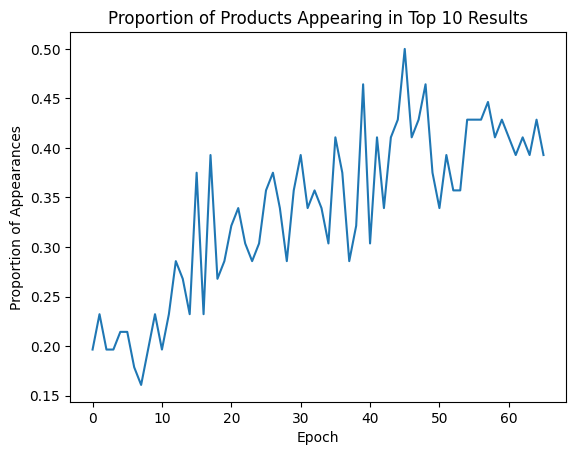

In [20]:
plt.plot(hits_in_top_k_history)
plt.xlabel("Epoch")
plt.ylabel("Proportion of Appearances")
plt.title("Proportion of Products Appearing in Top 10 Results")
plt.show()

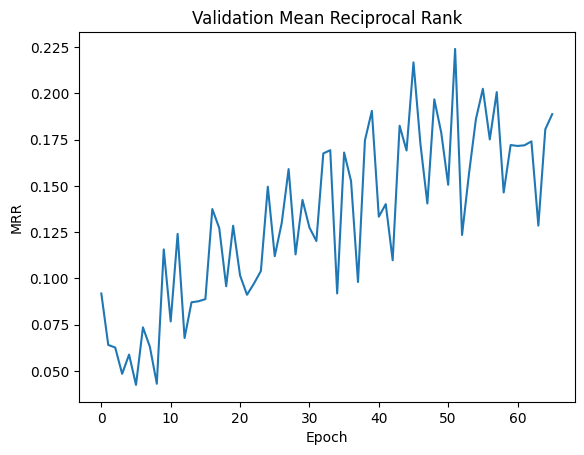

In [21]:
plt.plot(mrr_history)
plt.xlabel("Epoch")
plt.ylabel("MRR")
plt.title("Validation Mean Reciprocal Rank")
plt.show()

In [22]:
# Save models
torch.save(query_encoder.state_dict(), 'data/cd_and_vinyl_products_query_encoder.pt')
torch.save(product_encoder.state_dict(), 'data/cd_and_vinyl_products_description_encoder.pt')